# Определение перспективного тарифа для телеком компании


# Содержание
[Описание проекта](#description),
1. [Изучение данных](#1),
2. [Подготовка данных](#2),
   * [Количество сделанных звонков и израсходованных минут разговора по месяцам](#3),
   * [Объем израсходованного интернет-трафика по месяцам](#4),
   * [Количество отправленных сообщений по месяцам](#5),
   * [Помесячная выручка с каждого пользователя](#6),
3. [Анализ данных ](#7),
6. [Проверка гипотез](#8),
* [Общий вывод](#9),   


## Описание проекта <a id='description'></a>

### Описание тарифов
#### Тариф «Смарт»
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
    * минута разговора: 3 рубля
    * сообщение: 3 рубля
    * 1 Гб интернет-трафика: 200 рублей

#### Тариф «Ультра»
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
    * минута разговора: 1 рубль
    * сообщение: 1 рубль
    * 1 Гб интернет-трафика: 150 рублей

## 1. Изучение данных <a id='1'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import math
from scipy import stats as st
import seaborn as sn

In [2]:
data_calls = pd.read_csv('/datasets/calls.csv')
data_internet = pd.read_csv('/datasets/internet.csv')
data_messages = pd.read_csv('/datasets/messages.csv')
data_tariffs = pd.read_csv('/datasets/tariffs.csv')
data_users = pd.read_csv('/datasets/users.csv')

In [3]:
display(data_calls.head())
data_calls.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
del data_internet['Unnamed: 0']
display(data_internet)
data_internet.info()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


In [5]:
display(data_messages.head())
data_messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [6]:
display(data_tariffs.head())
data_tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [7]:
display(data_users.head())
data_users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


## 2. Подготовка данных <a id='2'></a>

#### Перевод данных к нужному типу

In [8]:
#В таблице data_calls поменяю тип данных call_date в datetime
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'],format = '%Y-%m-%d')

In [9]:
#В таблице data_calls поменяю тип данных session_date в datetime
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'],format = '%Y-%m-%d')

In [10]:
#В таблице data_meassges поменяю тип данных message_date в datetime
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'],format = '%Y-%m-%d')

In [11]:
#В таблице data_users поменяю тип данных churn_date и reg_date в datetime
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'],format = '%Y-%m-%d')
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'],format = '%Y-%m-%d')

#### Исправление ошибок в данных

Так как компания всегда округляет вверх значения минут и мегабайтов, выполню округление до верхнего значения.

In [12]:
data_calls['duration'] = np.ceil(data_calls['duration'])
display(data_calls.head())

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000


In [13]:
data_internet['mb_used'] = np.ceil(data_internet['mb_used'])
display(data_internet.head())

,id,mb_used,session_date,user_id
0,1000_0,113.0,2018-11-25,1000
1,1000_1,1053.0,2018-09-07,1000
2,1000_2,1198.0,2018-06-25,1000
3,1000_3,551.0,2018-08-22,1000
4,1000_4,303.0,2018-09-24,1000


Посчитаю уникальное количестов звонков, чтобы определить сколько было звонков длительностью 0 минут

In [14]:
data_calls['duration'].value_counts()

0.0     39613
7.0     11510
6.0     11457
5.0     11411
8.0     11272
9.0     10973
4.0     10918
3.0     10362
10.0    10186
11.0     9385
2.0      9194
12.0     8448
1.0      8402
13.0     7486
14.0     6554
15.0     5505
16.0     4551
17.0     3671
18.0     2984
19.0     2411
20.0     1806
21.0     1304
22.0      975
23.0      720
24.0      468
25.0      363
26.0      257
27.0      151
28.0      104
29.0       56
30.0       39
31.0       30
32.0       17
33.0       10
35.0        5
34.0        3
38.0        2
36.0        2
37.0        2
Name: duration, dtype: int64

Таких звонков было совершено 39613, это самое большое количество звонков. Есть несколько причин для появления таких значений: отсутствие соединения при наборе, "абонент занят/разговаривает", срыв звонка, отмена звонка после первого (нескольких) гудка(-ов), но так как номер был набран, то сам факт звонка уже был зафиксирован в базе. Считаю, что строки с такими звонками лучше вообще не брать в расчет, т.к. они лишь будут мешать верно рассчитывать все дальнейшие показатели. Чтобы убедиться в том, что строки с 0-значениями можно удалить, попробую сгруппировать данные по user_id и посчитать сумму минут всех их разговоров. Если нулевых сумм не будет, это означет, что абсолютно все изучаемые пользователи сотовой связи имеюи данные по реально совершенным звонкам, а 0-значения не несут никакой аналитической ценности и могут быть удалены.

In [15]:
calls_grouped_id = data_calls.groupby('user_id').sum()
calls_grouped_id.sort_values(by = 'duration')

,duration
user_id,
1257,66.0
1016,122.0
1373,136.0
1442,192.0
1141,211.0
...,...
1196,8690.0
1453,10269.0
1375,11398.0


Минимальное количество потраченных минут равно 66, следовательно 0 - значения длительности звонков не имеют смысла дальнейшего изучения данных. Сделаю выборку без длительности звонков равных 0.

In [16]:
data_calls_query = data_calls.query('duration > 0').reset_index(drop = True)
data_calls_query.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162994 entries, 0 to 162993
Data columns (total 4 columns):
id           162994 non-null object
call_date    162994 non-null datetime64[ns]
duration     162994 non-null float64
user_id      162994 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.0+ MB


Так же, как в data_calls, проверю наличие использованного трафика.

In [17]:
data_internet['mb_used'].value_counts()

0.0       19598
333.0       231
382.0       228
377.0       224
253.0       222
          ...  
1308.0        1
1456.0        1
1375.0        1
1364.0        1
1291.0        1
Name: mb_used, Length: 1424, dtype: int64

In [18]:
internet_grouped_id = data_internet.groupby('user_id').sum()
internet_grouped_id.sort_values(by = 'mb_used')

,mb_used
user_id,
1399,4608.0
1192,9044.0
1062,11090.0
1069,11367.0
1406,11446.0
...,...
1330,336694.0
1185,343845.0
1180,348532.0


Тут аналогичная ситуация: при суммировании израсходованного трафика по пользователям, нулевого трафика необнаружено.

In [19]:
data_internet_query = data_internet.query('mb_used > 0').reset_index(drop = True)
data_internet_query.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129798 entries, 0 to 129797
Data columns (total 4 columns):
id              129798 non-null object
mb_used         129798 non-null float64
session_date    129798 non-null datetime64[ns]
user_id         129798 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.0+ MB


Информация об имени и фамилии пользователей не несет для данного анализа никакого смысла, то считаю можно удалить их.

In [20]:
data_users_query = data_users.drop(columns = ['first_name', 'last_name'])
data_users_query.columns = ['user_id', 'age', 'churn_date', 'city', 'reg_date', 'tariff_name']
data_users_query.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
user_id        500 non-null int64
age            500 non-null int64
churn_date     38 non-null datetime64[ns]
city           500 non-null object
reg_date       500 non-null datetime64[ns]
tariff_name    500 non-null object
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 23.6+ KB


Добавлю в таблицы data_calls_query, data_internet_query, data_messages по одинаковому столбцу - месяц(month).

In [21]:
data_calls_query['month'] = data_calls_query['call_date'].dt.month
data_internet_query['month'] = data_internet_query['session_date'].dt.month
data_messages['month'] = data_messages['message_date'].dt.month

Составлю сводную таблицу, в которой сгруппирую значения количества звонков и суммарную длительность звонков по каждому пользователю в разрезе по месяцам.

In [22]:
call_pivot = data_calls_query.pivot_table(index = ['user_id', 'month'], values = 'duration', aggfunc = ['count', 'sum'])
call_pivot

count      sum
              duration duration
user_id month                  
1000    5           17    159.0
        6           28    172.0
        7           41    340.0
        8           42    408.0
        9           46    466.0
...                ...      ...
1498    10          30    247.0
1499    9            8     70.0
        10          44    449.0
        11          62    612.0
        12          56    492.0

[3168 rows x 2 columns]

### Посчитать для каждого пользователя: 

* количество сделанных звонков и израсходованных минут разговора по месяцам <a id='3'></a>

In [23]:
call_pivot = call_pivot.reset_index()
#Переименную столбцы
call_pivot.columns = ['user_id', 'month', 'calls_number', 'call_duration']
call_pivot

,user_id,month,calls_number,call_duration
0,1000,5,17,159.0
1,1000,6,28,172.0
2,1000,7,41,340.0
3,1000,8,42,408.0
4,1000,9,46,466.0
...,...,...,...,...
3163,1498,10,30,247.0
3164,1499,9,8,70.0
3165,1499,10,44,449.0
3166,1499,11,62,612.0


* объем израсходованного интернет-трафика по месяцам <a id='4'></a>

In [24]:
internet_pivot = data_internet_query.pivot_table(index = ['user_id', 'month'], 
                                                 values = 'mb_used', 
                                                 aggfunc = 'sum')
internet_pivot = internet_pivot.reset_index()
internet_pivot.columns = ['user_id', 'month', 'mb_used_sum']
internet_pivot

,user_id,month,mb_used_sum
0,1000,5,2256.0
1,1000,6,23257.0
2,1000,7,14016.0
3,1000,8,14070.0
4,1000,9,14581.0
...,...,...,...
3196,1498,10,20604.0
3197,1499,9,1848.0
3198,1499,10,17809.0
3199,1499,11,17984.0


In [25]:
#объединю сгруппированные таблицы
internet_calls = internet_pivot.merge(call_pivot, on = ['user_id', 'month'], how = 'left')
internet_calls

,user_id,month,mb_used_sum,calls_number,call_duration
0,1000,5,2256.0,17.0,159.0
1,1000,6,23257.0,28.0,172.0
2,1000,7,14016.0,41.0,340.0
3,1000,8,14070.0,42.0,408.0
4,1000,9,14581.0,46.0,466.0
...,...,...,...,...,...
3196,1498,10,20604.0,30.0,247.0
3197,1499,9,1848.0,8.0,70.0
3198,1499,10,17809.0,44.0,449.0
3199,1499,11,17984.0,62.0,612.0


* количество отправленных сообщений по месяцам. <a id='5'></a>

In [26]:
messages_pivot = data_messages.pivot_table(index = ['user_id', 'month'], 
                                           values = 'id', 
                                           aggfunc = 'count')
messages_pivot = messages_pivot.reset_index()
messages_pivot.columns = ['user_id', 'month', 'messages_sent']
messages_pivot

,user_id,month,messages_sent
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


In [27]:
#присоединю полученную таблицу к internet_calls
network = internet_calls.merge(messages_pivot, on = ['user_id', 'month'], how = 'left')
network.head()

,user_id,month,mb_used_sum,calls_number,call_duration,messages_sent
0,1000,5,2256.0,17.0,159.0,22.0
1,1000,6,23257.0,28.0,172.0,60.0
2,1000,7,14016.0,41.0,340.0,75.0
3,1000,8,14070.0,42.0,408.0,81.0
4,1000,9,14581.0,46.0,466.0,57.0


In [28]:
#теперь добавлю данные из таблицы users
network_users = network.merge(data_users_query, on = 'user_id', how = 'left')
network_users.head()

,user_id,month,mb_used_sum,calls_number,call_duration,messages_sent,age,churn_date,city,reg_date,tariff_name
0,1000,5,2256.0,17.0,159.0,22.0,52,NaT,Краснодар,2018-05-25,ultra
1,1000,6,23257.0,28.0,172.0,60.0,52,NaT,Краснодар,2018-05-25,ultra
2,1000,7,14016.0,41.0,340.0,75.0,52,NaT,Краснодар,2018-05-25,ultra
3,1000,8,14070.0,42.0,408.0,81.0,52,NaT,Краснодар,2018-05-25,ultra
4,1000,9,14581.0,46.0,466.0,57.0,52,NaT,Краснодар,2018-05-25,ultra


In [29]:
#Создам финальный датафрейм
final_df = network_users.merge(data_tariffs, on = 'tariff_name', how = 'left')
final_df

,user_id,month,mb_used_sum,calls_number,call_duration,messages_sent,age,churn_date,city,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,2256.0,17.0,159.0,22.0,52,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,23257.0,28.0,172.0,60.0,52,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,14016.0,41.0,340.0,75.0,52,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,14070.0,42.0,408.0,81.0,52,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,14581.0,46.0,466.0,57.0,52,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196,1498,10,20604.0,30.0,247.0,42.0,68,2018-10-25,Владикавказ,2018-07-19,smart,50,15360,500,550,200,3,3
3197,1499,9,1848.0,8.0,70.0,11.0,35,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3
3198,1499,10,17809.0,44.0,449.0,48.0,35,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3
3199,1499,11,17984.0,62.0,612.0,59.0,35,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3


In [30]:
f'Количество пользователей: {final_df.user_id.nunique()}'

'Количество пользователей: 497'

* Помесячная выручка с каждого пользователя. <a id='6'></a>

In [31]:
def month_revenue (final_df):
    call = final_df['call_duration']
    message = final_df['messages_sent']
    internet = final_df['mb_used_sum']
    abonent = final_df['rub_monthly_fee']
    
    if (call - final_df['minutes_included']) > 0:
        delta_call = (call - final_df['minutes_included']) * final_df['rub_per_minute']
    else:
        delta_call = 0
        
    if (message - final_df['messages_included']) > 0:
        delta_message = (message - final_df['messages_included']) * final_df['rub_per_message']
    else:
        delta_message = 0
        
    if (internet - final_df['mb_per_month_included']) > 0:
        delta_internet = (internet - final_df['mb_per_month_included'])/1000 * final_df['rub_per_gb']
    else:
        delta_internet = 0
        
    total = abonent + delta_call + delta_message + delta_internet
    return total

final_df['revenue'] = final_df.apply(month_revenue, axis = 1)
final_df

,user_id,month,mb_used_sum,calls_number,call_duration,messages_sent,age,churn_date,city,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
0,1000,5,2256.0,17.0,159.0,22.0,52,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
1,1000,6,23257.0,28.0,172.0,60.0,52,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
2,1000,7,14016.0,41.0,340.0,75.0,52,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
3,1000,8,14070.0,42.0,408.0,81.0,52,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
4,1000,9,14581.0,46.0,466.0,57.0,52,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196,1498,10,20604.0,30.0,247.0,42.0,68,2018-10-25,Владикавказ,2018-07-19,smart,50,15360,500,550,200,3,3,1598.8
3197,1499,9,1848.0,8.0,70.0,11.0,35,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3,550.0
3198,1499,10,17809.0,44.0,449.0,48.0,35,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3,1039.8
3199,1499,11,17984.0,62.0,612.0,59.0,35,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3,1437.8


### Анализ данных <a id='7'></a>

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2605cf8b10>],
      dtype=object)

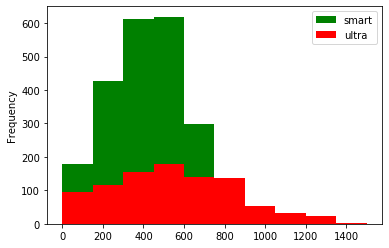

In [32]:
#Рассмотрю зависимости количества минут разговора по месяцам и тарифам
df_smart = final_df.query('tariff_name == "smart"')
df_ultra = final_df.query('tariff_name == "ultra"')

#df_smart['call_duration'].hist(color = 'g', range = (0, 1500), bins = 10)
df_smart['call_duration'].plot(kind = 'hist', subplots = True, legend = True, label = 'smart', color = 'g', range = (0, 1500), bins = 10)
#df_ultra['call_duration'].hist(color = 'r', range = (0, 1500), bins = 10)
df_ultra['call_duration'].plot(kind = 'hist', subplots = True, legend = True, label = 'ultra', color = 'r', range = (0, 1500), bins = 10)

На тарифе смарт пользователи тратят примерно 300-600 минут в месяц, пользователи тарифа ультра от 0 до 900 минут.

In [33]:
#Посчитаю среднее количество минут разговора по месяцам
call_mean = final_df.pivot_table(index = 'month', 
                                 columns = 'tariff_name', 
                                 values = 'call_duration', 
                                 aggfunc = 'mean')
call_mean

tariff_name,smart,ultra
month,,
1,210.030303,428.111111
2,298.689655,330.428571
3,390.051948,489.648649
4,370.441441,475.301887
5,387.361702,546.209677
6,398.067485,500.812500
7,408.353234,574.581395
8,424.871245,538.613861
9,430.266409,567.091743


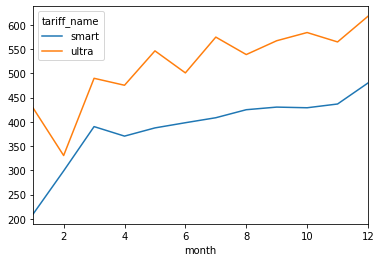

In [34]:
call_mean.plot()

По графику видно что в среднем пользователи тарифа ультра больше говорят по телефону примерно на 100-150 минут в месяц, исключение только февраль.

In [35]:
#Посчитаю дисперсию для количества минут разговора по месяцам
call_disp = final_df.pivot_table(index = 'month', 
                                 columns = 'tariff_name', 
                                 values = 'call_duration', 
                                 aggfunc = lambda x: np.var(x, ddof=1))
call_disp

tariff_name,smart,ultra
month,,
1,23192.717803,72769.361111
2,36412.287961,90794.857143
3,36823.155161,111384.900901
4,33857.994267,66036.830189
5,34820.061094,72579.348757
6,29960.520109,86191.622627
7,32250.269602,84005.210944
8,33721.448868,89342.099406
9,32950.529526,96419.047061


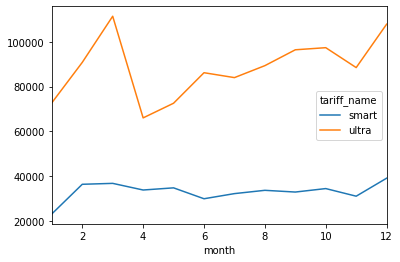

In [36]:
call_disp.plot()

In [37]:
#Посчитаю стандартное отклонение для количества минут разговора по месяцам
call_dev = call_disp = final_df.pivot_table(index = 'month', 
                                 columns = 'tariff_name', 
                                 values = 'call_duration', 
                                 aggfunc = lambda x: round(np.std(x), 2))
call_dev

tariff_name,smart,ultra
month,,
1,149.97,254.33
2,189.17,294.06
3,190.64,329.20
4,183.17,254.54
5,185.94,267.22
6,172.56,291.74
7,179.14,288.15
8,183.24,297.42
9,181.17,309.09


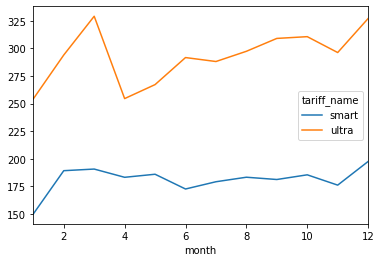

In [38]:
call_dev.plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f26060b07d0>],
      dtype=object)

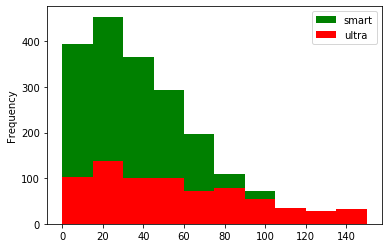

In [39]:
#Построю гистограммы для количества отправленных смс по тарифам
#df_smart['messages_sent'].hist(color = 'g', range = (0, 150), bins = 10)
#df_ultra['messages_sent'].hist(color = 'r', range = (0, 150), bins = 10)
df_smart['messages_sent'].plot(kind = 'hist', subplots = True, legend = True, label = 'smart', color = 'g', range = (0, 150), bins = 10)
df_ultra['messages_sent'].plot(kind = 'hist', subplots = True, legend = True, label = 'ultra', color = 'r', range = (0, 150), bins = 10)

In [40]:
#Посчитаю среднее для количества смс по месяцам
message_mean = final_df.pivot_table(index = 'month', 
                                 columns = 'tariff_name', 
                                 values = 'messages_sent', 
                                 aggfunc = 'mean')
message_mean

tariff_name,smart,ultra
month,,
1,20.000000,43.428571
2,27.940000,37.285714
3,35.550725,47.800000
4,35.864583,44.512821
5,39.032787,50.240000
6,38.577465,52.530303
7,38.988506,62.486111
8,38.935961,59.103448
9,39.219731,63.627660


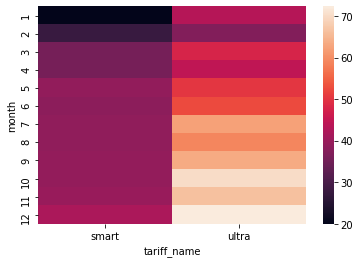

In [41]:
#message_mean.plot()
sn.heatmap(message_mean)

Пользователи тарифа ультра в среднем отправляют больше сообщений. В тарифе смарт пользователи отправляют в среднем одинаковое количество сообщений в месяц.

In [42]:
#Посчитаю дисперсию для количества смс по месяцам
message_disp = final_df.pivot_table(index = 'month', 
                                 columns = 'tariff_name', 
                                 values = 'messages_sent', 
                                 aggfunc = lambda x: np.var(x, ddof=1))
message_disp

tariff_name,smart,ultra
month,,
1,252.133333,765.285714
2,440.465714,660.219780
3,669.780477,1826.666667
4,517.865680,1408.256410
5,638.775776,1562.512653
6,731.635801,1962.252914
7,719.352468,2212.563185
8,763.921621,2042.721732
9,702.505555,1916.623313


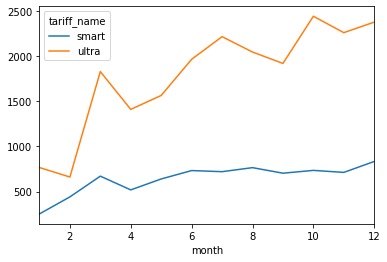

In [43]:
message_disp.plot()

In [44]:
#Посчитаю стандартное отклонение для количества смс по месяцам
message_dev = call_disp = final_df.pivot_table(index = 'month', 
                                 columns = 'tariff_name', 
                                 values = 'messages_sent', 
                                 aggfunc = lambda x: round(np.std(x), 2))
message_dev

tariff_name,smart,ultra
month,,
1,15.62,25.61
2,20.78,24.76
3,25.69,41.88
4,22.64,37.04
5,25.17,39.13
6,26.95,43.96
7,26.74,46.71
8,27.57,44.94
9,26.45,43.55


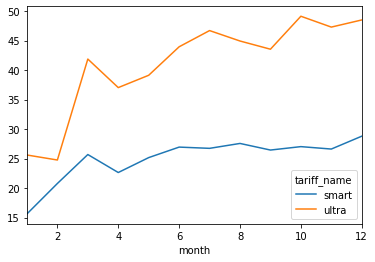

In [45]:
message_dev.plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2604676bd0>],
      dtype=object)

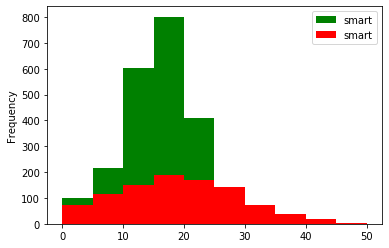

In [46]:
#Построю гистограммы для количества Гб по тарифам
(df_smart['mb_used_sum'] / 1024).plot(kind = 'hist', subplots = True, legend = True, label = 'smart', color = 'g', range = (0, 50), bins = 10)
(df_ultra['mb_used_sum'] / 1024).plot(kind = 'hist', subplots = True, legend = True, label = 'smart', color = 'r', range = (0, 50), bins = 10)

In [47]:
#Посчитаю среднее для количества использованного интернета по месяцам
internet_mean = final_df.pivot_table(index = 'month', 
                                 columns = 'tariff_name', 
                                 values = 'mb_used_sum', 
                                 aggfunc = 'mean')
internet_mean

tariff_name,smart,ultra
month,,
1,8524.441176,13153.555556
2,11611.396552,12858.500000
3,15123.857143,17551.972973
4,13479.482143,16843.800000
5,15825.198582,19977.538462
6,15814.768293,19170.457831
7,15763.512438,20742.588889
8,16703.252137,19778.915094
9,16324.526923,19390.824561


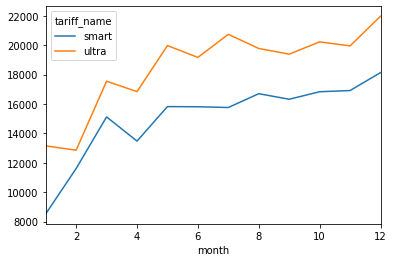

In [48]:
internet_mean.plot()

В среднее пользователи тарифа ультра используют на 2-4 Гб больше в месяц.

In [49]:
#Посчитаю дисперсию для количества использованного интернета по месяцам
internet_disp = final_df.pivot_table(index = 'month', 
                                 columns = 'tariff_name', 
                                 values = 'mb_used_sum', 
                                 aggfunc = lambda x: np.var(x, ddof=1))
internet_disp

tariff_name,smart,ultra
month,,
1,4.162621e+07,4.722641e+07
2,3.911935e+07,1.098915e+08
3,3.405260e+07,1.201640e+08
4,3.254736e+07,9.462393e+07
5,3.582236e+07,9.217600e+07
6,3.361642e+07,8.314920e+07
7,3.486110e+07,9.783655e+07
8,3.030580e+07,1.073123e+08
9,2.706215e+07,8.764804e+07


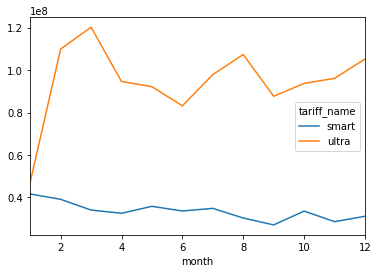

In [50]:
internet_disp.plot()

In [51]:
#Посчитаю стандартное отклонение для количества использованного интернета по месяцам
internet_dev = call_disp = final_df.pivot_table(index = 'month', 
                                 columns = 'tariff_name', 
                                 values = 'mb_used_sum', 
                                 aggfunc = lambda x: round(np.std(x), 2))
internet_dev

tariff_name,smart,ultra
month,,
1,6356.25,6479.12
2,6200.39,10241.89
3,5797.44,10812.79
4,5679.50,9638.65
5,5963.92,9526.69
6,5780.26,9063.52
7,5889.62,9836.13
8,5493.29,10310.18
9,5192.12,9320.90


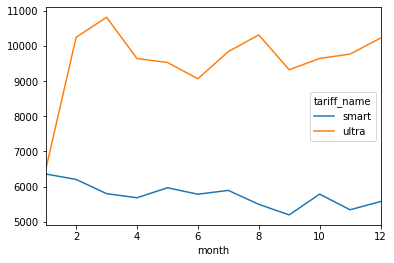

In [52]:
internet_dev.plot()

In [53]:
final_df['revenue'].describe()

count    3201.000000
mean     1495.710512
std       794.862275
min       550.000000
25%       694.600000
50%      1567.000000
75%      1950.000000
max      6820.000000
Name: revenue, dtype: float64

In [54]:
#Посчитаю среднюю стоимость по месяцам
revenue_mean = final_df.pivot_table(index = 'month',
                                   columns = 'tariff_name',
                                   values = 'revenue',
                                   aggfunc = 'mean')
revenue_mean

tariff_name,smart,ultra
month,,
1,706.058824,1950.000000
2,809.241379,1975.745455
3,1129.179221,2005.471622
4,929.076786,1996.521818
5,1158.882270,2060.792308
6,1161.443902,2035.042771
7,1180.000000,2114.110000
8,1275.208547,2075.230189
9,1211.143846,2015.827632


Пользователи тарифа ультра в среднем немного превышают свой тариф за 1950. Пользователи тарифа смарт значительно превышают свой лимит за 550.

### Проверка гипотез <a id='8'></a>

##### Средняя выручка пользователей тарифов ультра и смарт различается

Применю гипотезу о равенстве средней выручки пользователей тарифа смарт и ультра. Критический уровень статической значимости приму 0.05

* Средняя выручка пользователя тарифа смарт - 1246.96.
* Средняя выручка пользователя тарифа ультра - 2064.46.

#### Нулевая гипотеза H₀: 
средняя выручка пользователей тарифов ультра и смарт не различается.

#### Исходя из H₀ формулируется альтернативная гипотеза H₁: 
средняя выручка пользователей тарифов ультра и смарт различается.

In [55]:
df_smart = final_df.query('tariff_name == "smart"')
df_ultra = final_df.query('tariff_name == "ultra"')

alpha = 0.05

result = st.ttest_ind(df_smart['revenue'], df_ultra['revenue'])

print('p-значение:', result.pvalue)

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 2.0608632443775105e-178
Отвергаем нулевую гипотезу


Полученное значение p-value очень мало, следует что значимо различие средней выручки по двум тарифам.

##### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [56]:
revenue_moscow = final_df.query('city == "Москва"')
revenue_other = final_df.query('city != "Москва"')

print(revenue_moscow['revenue'].mean())
print(revenue_other['revenue'].mean())

1515.902782324059
1490.9470077220078


* Средняя выручка пользователей из Москвы - 1515.90.
* Средняя выручка пользователей из других регионов - 1490.95.

#### Нулевая гипотеза H₀: 
Cредняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

#### Исходя из H₀ формулируется альтернативная гипотеза H₁: 
Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [57]:
alpha = 0.05

result2 = st.ttest_ind(revenue_moscow['revenue'], revenue_other['revenue'])

print('p-значение', result2.pvalue)

if result2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение 0.48521124320582887
Не получилось отвергнуть нулевую гипотезу


p-значение настолько велико, что означает что с вероятностью > 48% различие в показателях средней выручки по абонента в Москве и не в Москве может получиться случайно. Выручка скорее всего в Москве и других регионах будет совпадать.

Значения средней выручки максимально близки к друг другу, поэтому гипотезу об их разлии принять невозможно.

## Общий вывод <a id='9'></a>

Анализ показал что пользователи тарифа смарт тратят примерно 300-600 минут в месяц, а пользователи тарифа ультра от 0 до 900 минут. В среднем пользователи тарифа ультра на звонки тратят больше на 100-150 минут, исключение только февраль. Пользователи тарифа ультра в среднем отправляют больше сообщений. В тарифе смарт пользователи отправляют в среднем одинаковое количество сообщений в месяц. В среднее пользователи тарифа ультра используют на 2-4 Гб больше в месяц. Среднее значение использования интернета растет к концу года. Пользователи тарифа ультра в среднем немного превышают свой тариф за 1950. Пользователи тарифа смарт значительно превышают свой лимит за 550. Было выдвинуто и проверено 2 гипотезы: средняя выручка пользователей тарифов различается, средняя выручка пользователей Москвы и других городов не совпадает.

